In [8]:
import pathlib
from importlib import reload
import numpy as np
import torch
import matplotlib.pyplot as plt

import lab3
reload(lab3)

import lab3.classes
reload(lab3.classes)
import lab3.classes as cs

import lab3.show
reload(lab3.show)
from lab3.show import display_img_with_masks, display_masks, display_img_with_masks_nouveau

import lab3.trans
reload(lab3.trans)
from lab3.trans import validation_trans, train_trans, test_trans

import lab3.dataset
reload(lab3.dataset)
from lab3.dataset import FiftyOneDataset

import lab3.net
reload(lab3.net)
from lab3.net import Net

import lab1.device
reload(lab1.device)
from lab1.device import device

import lab3.util as lu
reload(lab3.util)
from lab3.util import seconds_to_time, pickle_data

device

device(type='mps')

IMG MIN MAX: 0.0 1.0
MSK MIN MAX: 0.0 1.0
MSK UNIQUE:  tensor([0., 1.])


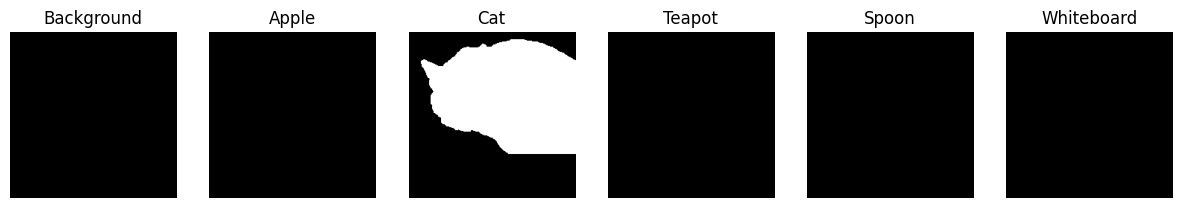

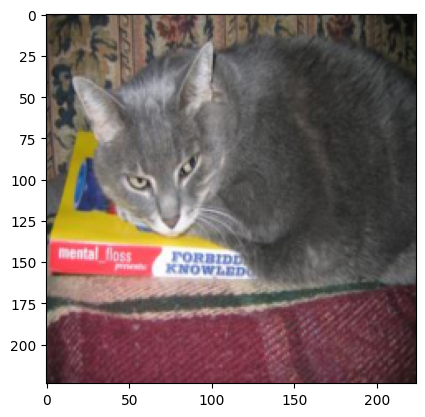

In [9]:
import torch
import torch.utils.data as tud
from torchvision.tv_tensors import Mask, Image
import torchvision.transforms.v2 as v2
from torchvision.transforms.v2 import functional as F

import lab3.util as lu
import lab3.dataset
reload(lab3.dataset)
from lab3.dataset import FiftyOneDataset

train_dataset = FiftyOneDataset('data-lab3-dyi/train.pkl', train_trans, split = 'train')
test_dataset = FiftyOneDataset('data-lab3-dyi/test.pkl', test_trans, split = 'test')
valid_dataset = FiftyOneDataset('data-lab3-dyi/valid.pkl', validation_trans, split = 'validation')

num_workers = 12 # M3 Pro
# num_workers = 8 # M1
batch_size = 32

train_ld = tud.DataLoader(
  train_dataset,
  batch_size = batch_size,
  num_workers = num_workers,
  shuffle = True,
  collate_fn = lu.unzipListIntoList
)
valid_ld = tud.DataLoader(
  valid_dataset,
  batch_size = batch_size,
  num_workers = num_workers,
  shuffle = False,
  collate_fn = lu.unzipListIntoList
)

# print(f'Train: {len(train_dataset)}, Test: {len(valid_dataset)}')

img = test_dataset[0][0]
masks = test_dataset[0][1]

print(f"IMG MIN MAX: {img.min()} {img.max()}")
print(f"MSK MIN MAX: {masks.min()} {masks.max()}")
print(f"MSK UNIQUE:  {masks.unique()}")

display_img_with_masks_nouveau(img, masks, cs.classes)

In [10]:
from statistics import mean
from sklearn.metrics import f1_score
from lab3.net import DIM
from torch import tensor as t, concat as c

class Stats:
  length = 0
  
  dice: float = 0
  iou:  float  = 0
  f1_micro: float = 0
  f1_macro: float = 0
  
  loss_acum: list[float] = []
  
  def init(self):
    pass
  
  def add_data(self, ys: torch.Tensor, y_hats: torch.Tensor, loss: float):
    # print(f"TYPE: {type(ys)}")
    # print(f"LEN:  {ys}")
    self.length += ys.shape[0]
    self.loss_acum.append(loss)

    intersection = torch.bitwise_and(ys, y_hats)
    union = torch.bitwise_or(ys, y_hats)

    intersection = torch.sum(intersection)
    union = torch.sum(union)

    # Jaccard = || A \intersect B || / || A \union B ||
    iou = intersection / union

    # DICE = 2 || A \intersect B || / (||A|| + ||B||)
    dice = 2 * intersection / (torch.sum(ys) + torch.sum(y_hats))

    # Flatten the tensors
    ys_flat = ys.view(-1).numpy()
    y_hats_flat = y_hats.view(-1).numpy()

    # Calculate Micro-F1 and Macro-F1 scores
    micro_f1 = f1_score(ys_flat, y_hats_flat, average='micro')
    macro_f1 = f1_score(ys_flat, y_hats_flat, average='macro')
    
    self.iou  += iou.item()
    self.dice += dice.item()
    self.f1_macro += macro_f1.item()
    self.f1_micro += micro_f1.item()
  
  def get_stats(self):
    return (
      self.iou / self.length, 
      self.dice / self.length,
      self.f1_micro / self.length,
      self.f1_macro / self.length,
      mean(self.loss_acum)
    )

def process_for_cross_entroppy(masks):
  """
  WARNING: NOT MEANT FOR PREDICTIONS OR IMAGES WITH MULTIPLE MASKS [TODO: FIX THIS]
  """
  index = masks.max(dim = -1)[0].max(dim = -1)[0].argmax()
  index
  return masks[index, :,:] * index
  

def run_epoch(model:   Net,
              loader:  torch.utils.data.DataLoader,
              loss_fn, optimizer = None):
  stats = Stats()
  IS_TRAIN = optimizer is not None
  
  if IS_TRAIN:
    model.train()
  else:
    model.eval()

  ix = -1
  for images, true_masks in loader:
    images = torch.stack(images).to(device)
    true_masks = torch.stack(true_masks).to(device)
    
    if not IS_TRAIN:
      with torch.no_grad():
        predictions = model(images)
    else:
      predictions = model(images)

    # for ix in range(cs.num_classes):
    #   loss = loss_fn(true_masks[ix], predictions[ix])
    #   print(f"      {ix} loss: {loss}")
    
    ys = torch.zeros((0, DIM, DIM)).to(device)
    for ix in range(true_masks.shape[0]):
      sample = true_masks[ix]
      _y = process_for_cross_entroppy(sample).unsqueeze(0)
      
      # print(f"_y {_y.shape}")
      # print(f"ys {ys.shape}")
      
      ys = torch.cat((ys, _y), dim = 0)

    # print(f"ys   {ys.shape}")
    # print(f"pred {predictions.shape}")
    # 
    # print(f"loss_fn {loss_fn}")
    loss = loss_fn(predictions, ys)
    
    print(f"    PRED RANGE: [{predictions.min()} {predictions.max()}]")
    print(f"    loss: {loss}")
    
    predictions = predictions > 0.5
    true_masks = true_masks > 0.5
    stats.add_data(true_masks.cpu().detach(), predictions.cpu().detach(), loss.cpu().detach().item())
    
    if IS_TRAIN:
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    if ix == 0:
      break
    ix -= 1
  
  ret = stats.get_stats()
  return ret


In [11]:
from datetime import datetime

def train_and_eval(model, train_ld, valid_ld, offset = 1, epoch_count = 10, learning_rate = 1e-3):
  loss_func = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

  start_time = datetime.now()

  train_loss_acum  = []
  train_iou_acum   = []
  train_dice_acum  = []
  train_micro_acum = []
  train_macro_acum = []
  valid_loss_acum  = []
  valid_iou_acum   = []
  valid_dice_acum  = []
  valid_micro_acum = []
  valid_macro_acum = []
  
  for epoch in range(offset, offset + epoch_count + 1):
    print(f'EPOCH: {epoch} / {offset + epoch_count}')
    train_iou, train_dice, train_micro, train_macro, train_loss = run_epoch(model, train_ld, loss_func, optimizer)
    
    current_time = datetime.now()
    elapsed = seconds_to_time((current_time - start_time).total_seconds())
    print(f'  train      | Elapsed: {elapsed}')

    valid_iou, valid_dice, valid_micro, valid_macro, valid_loss = run_epoch(model, valid_ld, loss_func)
    
    current_time = datetime.now()
    elapsed = seconds_to_time((current_time - start_time).total_seconds())
    print(f'  valid      | Elapsed: {elapsed}')

    train_iou_acum.append(train_iou)
    train_dice_acum.append(train_dice)
    train_micro_acum.append(train_micro)
    train_macro_acum.append(train_macro)
    train_loss_acum.append(train_loss)
    
    valid_iou_acum.append(valid_iou)
    valid_dice_acum.append(valid_dice)
    valid_micro_acum.append(valid_micro)
    valid_macro_acum.append(valid_macro)
    valid_loss_acum.append(valid_loss)

    print(f'  Training Loss:  {train_loss},  Validation Loss:  {valid_loss}')
    print(f'  Training IoU:   {train_iou},   Validation IoU:   {valid_iou}')
    print(f'  Training Dice:  {train_dice},  Validation Dice:  {valid_dice}')
    print(f'  Training Micro: {train_micro}, Validation Micro: {valid_micro}')
    print(f'  Training Macro: {train_macro}, Validation Macro: {valid_macro}')
    
    torch.save(model, f"lab3/save/net_attempt5-{epoch}.pt")

    img_, _ = valid_dataset[37]
    prediction_ = model(img.unsqueeze(0).to(device)).cpu().detach().squeeze(0)
    display_img_with_masks_nouveau(img_, prediction_, cs.classes)

  return train_iou_acum, valid_iou_acum, train_dice_acum, valid_dice_acum, train_micro_acum, valid_micro_acum, train_macro_acum, valid_macro_acum, train_loss_acum, valid_loss_acum

In [12]:
def plot(train, valid, label = "IoU"):
  plt.clf()
  plt.plot(train, 'b', label = f'Training {label}')
  plt.plot(valid, 'r', label = f'Validation {label}')
  plt.ylim(0.0, 1.0)
  plt.legend()
  plt.show()

Parameter count: 7,766,150
EPOCH: 62 / 92
    PRED RANGE: [1.3955071132132184e-26 1.0]
    loss: 1.2261645793914795
    PRED RANGE: [7.349649184343536e-21 1.0]
    loss: 1.2274677753448486
    PRED RANGE: [1.3059861916126065e-26 1.0]
    loss: 1.2268073558807373
    PRED RANGE: [4.970804566231039e-20 1.0]
    loss: 1.2062830924987793
    PRED RANGE: [9.825972549342401e-25 1.0]
    loss: 1.1930261850357056
    PRED RANGE: [8.783111991187032e-26 1.0]
    loss: 1.2389631271362305
    PRED RANGE: [1.8820774302970034e-18 1.0]
    loss: 1.3007336854934692
    PRED RANGE: [7.398796475867544e-20 1.0]
    loss: 1.1773301362991333
    PRED RANGE: [7.960397666504637e-21 1.0]
    loss: 1.2863361835479736
    PRED RANGE: [6.643831177197823e-29 1.0]
    loss: 1.188834547996521
    PRED RANGE: [1.4260200849623234e-18 1.0]
    loss: 1.268801212310791
    PRED RANGE: [9.614226505162977e-24 1.0]
    loss: 1.230678915977478
    PRED RANGE: [9.806310534238623e-18 1.0]
    loss: 1.3219166994094849
    PRED

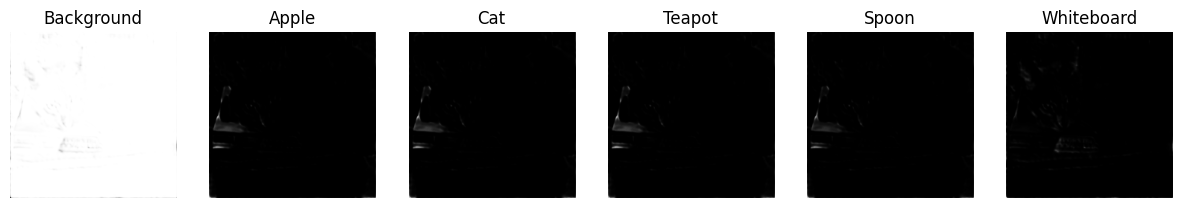

EPOCH: 63 / 92
    PRED RANGE: [1.4360774172885217e-23 1.0]
    loss: 1.2420121431350708
    PRED RANGE: [1.2710376184966992e-23 1.0]
    loss: 1.2438691854476929
    PRED RANGE: [2.805374161744357e-21 1.0]
    loss: 1.2417174577713013
    PRED RANGE: [4.593256532164055e-23 1.0]
    loss: 1.189821720123291
    PRED RANGE: [1.506254798961345e-22 1.0]
    loss: 1.233659029006958
    PRED RANGE: [1.0674968835377104e-35 1.0]
    loss: 1.2736778259277344
    PRED RANGE: [1.2956270440011623e-23 1.0]
    loss: 1.2653380632400513
    PRED RANGE: [1.4700593559964309e-24 1.0]
    loss: 1.2702676057815552
    PRED RANGE: [1.806153472250877e-27 1.0]
    loss: 1.201345443725586
    PRED RANGE: [8.963463219087885e-31 1.0]
    loss: 1.1691128015518188
    PRED RANGE: [1.7762327174338193e-20 1.0]
    loss: 1.1948806047439575
    PRED RANGE: [0.0 1.0]
    loss: 1.2870283126831055
    PRED RANGE: [3.2189531084238356e-22 1.0]
    loss: 1.2306239604949951
    PRED RANGE: [6.91310623165581e-21 1.0]
    los

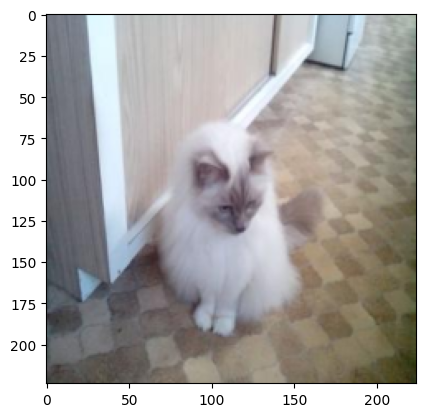

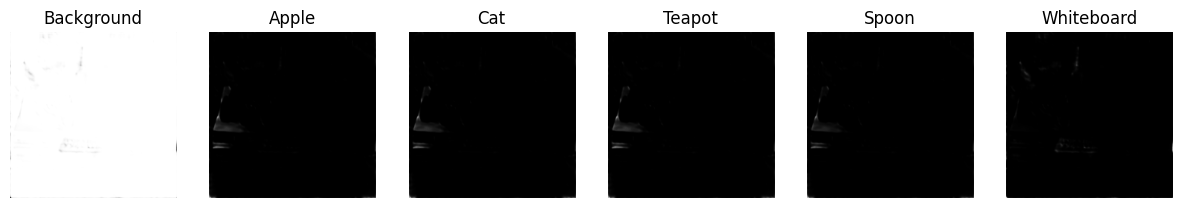

EPOCH: 64 / 92
    PRED RANGE: [0.0 1.0]
    loss: 1.2670419216156006
    PRED RANGE: [7.290406412908227e-33 1.0]
    loss: 1.1933009624481201
    PRED RANGE: [1.6330082641678231e-25 1.0]
    loss: 1.267780065536499
    PRED RANGE: [3.7957407553853565e-26 1.0]
    loss: 1.212233066558838
    PRED RANGE: [1.9446496345268957e-36 1.0]
    loss: 1.2606098651885986
    PRED RANGE: [3.774314730502633e-33 1.0]
    loss: 1.2194339036941528
    PRED RANGE: [3.1622876536826703e-28 1.0]
    loss: 1.2344545125961304
    PRED RANGE: [8.146353093706037e-34 1.0]
    loss: 1.2422529458999634
    PRED RANGE: [1.5143312622228034e-38 1.0]
    loss: 1.2717914581298828
    PRED RANGE: [0.0 1.0]
    loss: 1.2063360214233398
    PRED RANGE: [1.6256298570690405e-26 1.0]
    loss: 1.2368555068969727
    PRED RANGE: [7.748197203684622e-27 1.0]
    loss: 1.2033121585845947
    PRED RANGE: [1.2560851741902102e-24 1.0]
    loss: 1.1826426982879639
    PRED RANGE: [3.1644478248565436e-28 1.0]
    loss: 1.2457075119

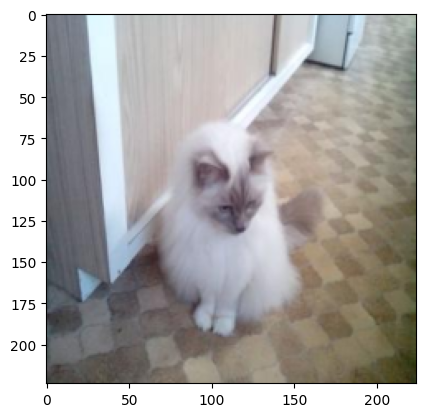

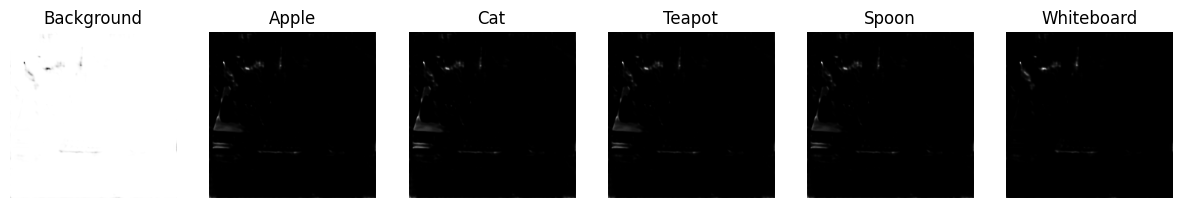

EPOCH: 65 / 92
    PRED RANGE: [0.0 1.0]
    loss: 1.1896920204162598
    PRED RANGE: [4.146551822169007e-27 1.0]
    loss: 1.2314835786819458
    PRED RANGE: [3.6260661732104454e-27 1.0]
    loss: 1.2237977981567383
    PRED RANGE: [0.0 1.0]
    loss: 1.2341581583023071
    PRED RANGE: [7.272771793593985e-32 1.0]
    loss: 1.228827953338623
    PRED RANGE: [5.870461780762134e-23 1.0]
    loss: 1.2016417980194092
    PRED RANGE: [0.0 1.0]
    loss: 1.2615289688110352
    PRED RANGE: [0.0 1.0]
    loss: 1.2079212665557861
    PRED RANGE: [1.2069413923626041e-26 1.0]
    loss: 1.3048707246780396
    PRED RANGE: [2.652301664409473e-26 1.0]
    loss: 1.2475450038909912
    PRED RANGE: [6.69285538689446e-27 1.0]
    loss: 1.1889417171478271
    PRED RANGE: [5.532655158724167e-27 1.0]
    loss: 1.1625581979751587
    PRED RANGE: [1.5394296185783819e-22 1.0]
    loss: 1.2909215688705444
    PRED RANGE: [1.097585171337358e-31 1.0]
    loss: 1.219364881515503
    PRED RANGE: [0.0 1.0]
    loss:

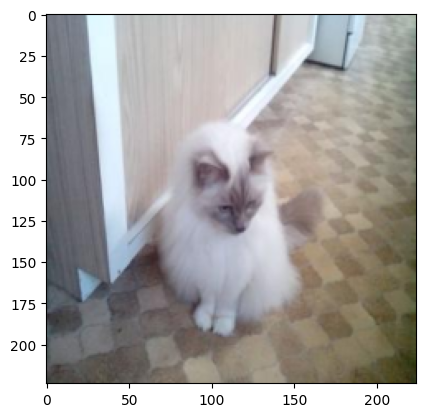

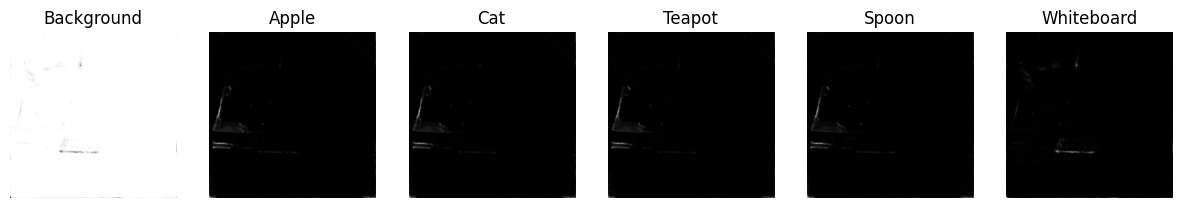

EPOCH: 66 / 92
    PRED RANGE: [6.1102895345837285e-37 1.0]
    loss: 1.25327730178833
    PRED RANGE: [1.0023386839766706e-27 1.0]
    loss: 1.2325596809387207
    PRED RANGE: [1.7455867295586573e-30 1.0]
    loss: 1.290054202079773
    PRED RANGE: [9.983762085326518e-24 1.0]
    loss: 1.2528878450393677
    PRED RANGE: [4.1976871881224324e-27 1.0]
    loss: 1.2164603471755981
    PRED RANGE: [3.101245918466969e-25 1.0]
    loss: 1.2031378746032715
    PRED RANGE: [3.603060653446364e-23 1.0]
    loss: 1.191318392753601
    PRED RANGE: [2.0439605610290076e-27 1.0]
    loss: 1.21915864944458
    PRED RANGE: [9.331150671857338e-25 1.0]
    loss: 1.2215873003005981
    PRED RANGE: [4.39677733976623e-32 1.0]
    loss: 1.2138925790786743
    PRED RANGE: [1.048295946533368e-28 1.0]
    loss: 1.2240456342697144
    PRED RANGE: [4.846071918757806e-27 1.0]
    loss: 1.2710150480270386
    PRED RANGE: [7.135256586963039e-32 1.0]
    loss: 1.269702672958374
    PRED RANGE: [5.8408535432925646e-24

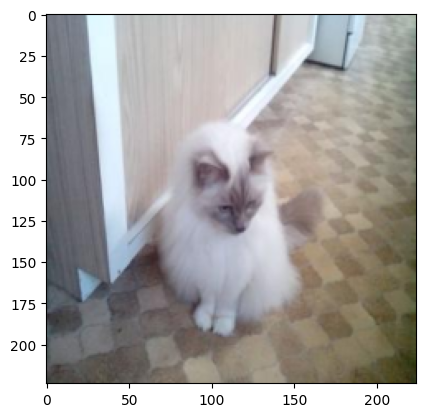

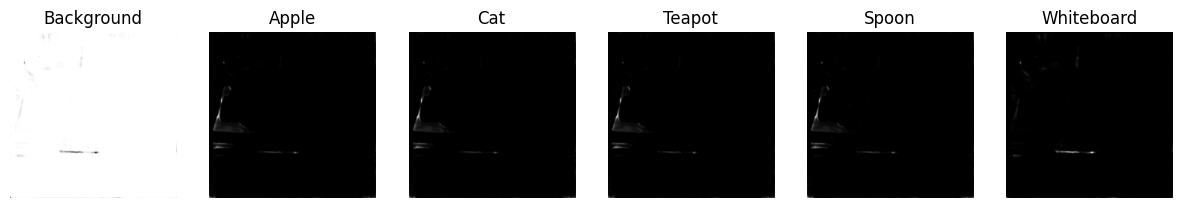

EPOCH: 67 / 92
    PRED RANGE: [7.439529951156952e-21 1.0]
    loss: 1.2378246784210205
    PRED RANGE: [6.23733027643931e-26 1.0]
    loss: 1.2215834856033325
    PRED RANGE: [0.0 1.0]
    loss: 1.2290273904800415
    PRED RANGE: [1.9136180135131527e-26 1.0]
    loss: 1.1849722862243652
    PRED RANGE: [1.558215252408171e-25 1.0]
    loss: 1.3155614137649536
    PRED RANGE: [5.206305466831135e-25 1.0]
    loss: 1.2804607152938843
    PRED RANGE: [0.0 1.0]
    loss: 1.2554887533187866
    PRED RANGE: [3.0418076298396325e-33 1.0]
    loss: 1.2464333772659302
    PRED RANGE: [4.0627535317679495e-26 1.0]
    loss: 1.3020979166030884
    PRED RANGE: [2.0059460285187013e-33 1.0]
    loss: 1.206449031829834
    PRED RANGE: [1.295068140980194e-25 1.0]
    loss: 1.2362468242645264
    PRED RANGE: [7.014843994393255e-22 1.0]
    loss: 1.2191343307495117
    PRED RANGE: [2.055586312135895e-20 1.0]
    loss: 1.1827640533447266
    PRED RANGE: [4.1434895368284714e-20 1.0]
    loss: 1.1999059915542

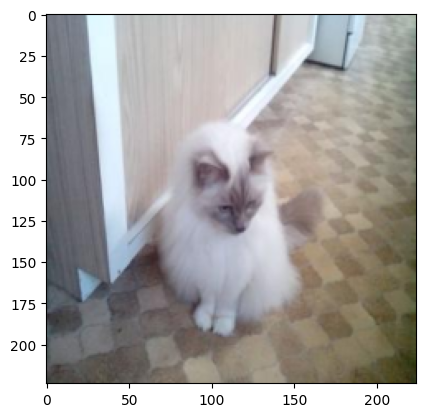

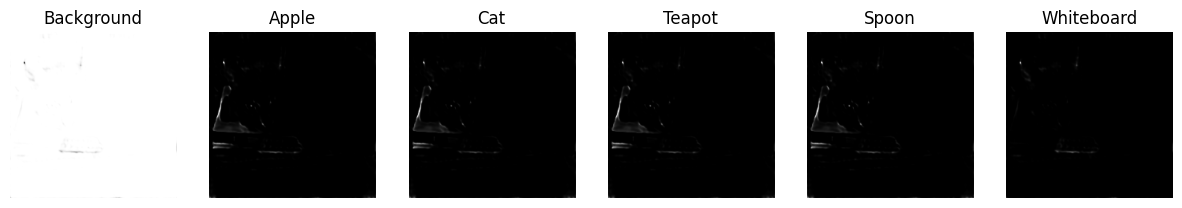

EPOCH: 68 / 92
    PRED RANGE: [7.205069431557245e-30 1.0]
    loss: 1.2066664695739746
    PRED RANGE: [1.471246117917253e-35 1.0]
    loss: 1.2044073343276978
    PRED RANGE: [1.8260052640610005e-38 1.0]
    loss: 1.2363418340682983
    PRED RANGE: [3.641741232768378e-29 1.0]
    loss: 1.2313224077224731
    PRED RANGE: [4.90716793245713e-25 1.0]
    loss: 1.2118200063705444
    PRED RANGE: [0.0 1.0]
    loss: 1.2962828874588013
    PRED RANGE: [0.0 1.0]
    loss: 1.2375152111053467
    PRED RANGE: [2.4644663717495667e-27 1.0]
    loss: 1.220596194267273
    PRED RANGE: [1.0494163368828584e-33 1.0]
    loss: 1.2767277956008911
    PRED RANGE: [0.0 1.0]
    loss: 1.2270143032073975
    PRED RANGE: [8.752190936330696e-37 1.0]
    loss: 1.2034803628921509
    PRED RANGE: [2.5457508031498726e-37 1.0]
    loss: 1.2361303567886353
    PRED RANGE: [8.801916449542383e-36 1.0]
    loss: 1.2488030195236206
    PRED RANGE: [2.7287560083762426e-28 1.0]
    loss: 1.1580841541290283
    PRED RANGE

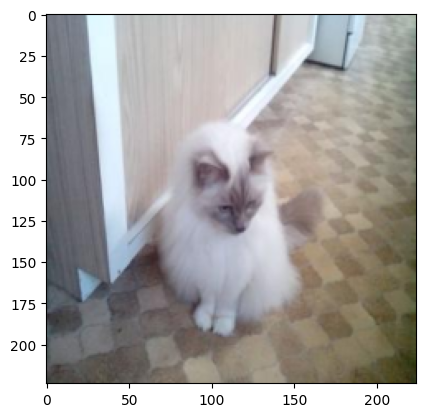

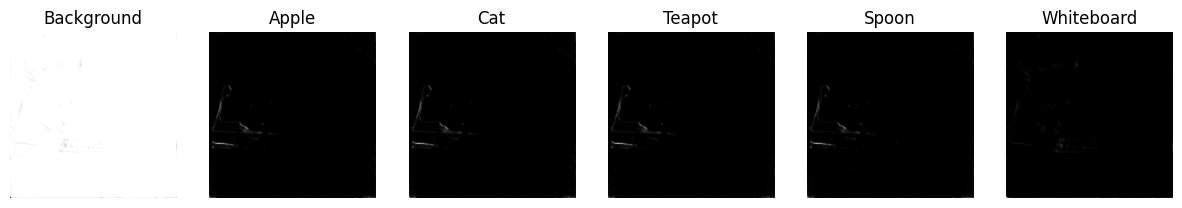

EPOCH: 69 / 92
    PRED RANGE: [6.7981166727263e-30 1.0]
    loss: 1.1752958297729492
    PRED RANGE: [1.0876188002843792e-25 1.0]
    loss: 1.2475767135620117
    PRED RANGE: [7.774604661430844e-20 1.0]
    loss: 1.2154667377471924
    PRED RANGE: [1.1697647562575095e-31 1.0]
    loss: 1.2607245445251465
    PRED RANGE: [0.0 1.0]
    loss: 1.1596354246139526
    PRED RANGE: [9.67768083437051e-35 1.0]
    loss: 1.236191987991333
    PRED RANGE: [5.4554374267285065e-36 1.0]
    loss: 1.2248033285140991
    PRED RANGE: [1.0463390187465258e-26 1.0]
    loss: 1.2988120317459106
    PRED RANGE: [1.7378561637731086e-38 1.0]
    loss: 1.2122377157211304
    PRED RANGE: [0.0 1.0]
    loss: 1.236215591430664
    PRED RANGE: [7.150972946433533e-32 1.0]
    loss: 1.244462013244629
    PRED RANGE: [0.0 1.0]
    loss: 1.238869547843933
    PRED RANGE: [6.735142645497381e-28 1.0]
    loss: 1.2661571502685547
    PRED RANGE: [1.3028380048355676e-31 1.0]
    loss: 1.2686870098114014
    PRED RANGE: [6

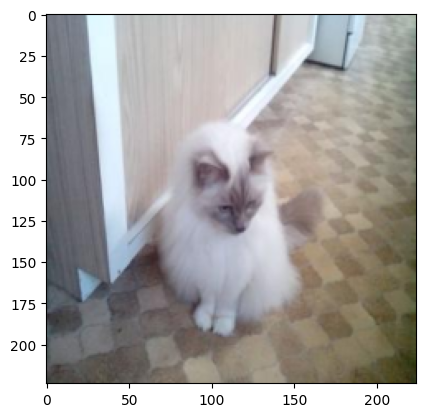

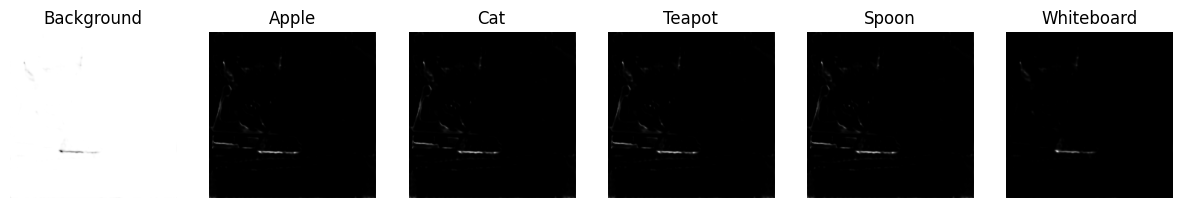

EPOCH: 70 / 92
    PRED RANGE: [1.8302278242776741e-23 1.0]
    loss: 1.2104578018188477
    PRED RANGE: [6.318470167219531e-25 1.0]
    loss: 1.235678791999817
    PRED RANGE: [2.3259367129766443e-32 1.0]
    loss: 1.2297358512878418
    PRED RANGE: [0.0 1.0]
    loss: 1.1584936380386353
    PRED RANGE: [4.0440176564298033e-32 1.0]
    loss: 1.2896524667739868
    PRED RANGE: [1.0504962312168642e-30 1.0]
    loss: 1.2665033340454102
    PRED RANGE: [0.0 1.0]
    loss: 1.2440937757492065
    PRED RANGE: [3.644178737854243e-29 1.0]
    loss: 1.225711464881897
    PRED RANGE: [2.2106243159644836e-35 1.0]
    loss: 1.240957260131836
    PRED RANGE: [0.0 1.0]
    loss: 1.2326221466064453
    PRED RANGE: [5.559317531253473e-30 1.0]
    loss: 1.2216368913650513
    PRED RANGE: [2.9066988805500112e-33 1.0]
    loss: 1.2863458395004272
    PRED RANGE: [2.679605457675254e-27 1.0]
    loss: 1.270057201385498
    PRED RANGE: [0.0 1.0]
    loss: 1.2553752660751343
    PRED RANGE: [3.33535508960933

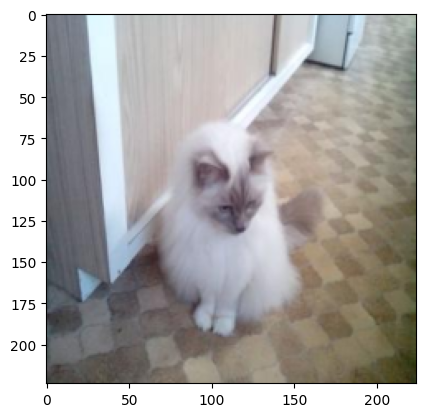

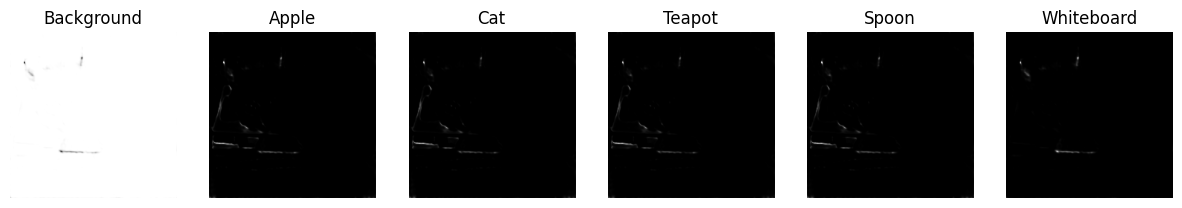

EPOCH: 71 / 92
    PRED RANGE: [0.0 1.0]
    loss: 1.2445333003997803
    PRED RANGE: [6.536527961457339e-26 1.0]
    loss: 1.227091670036316
    PRED RANGE: [2.037030029713678e-32 1.0]
    loss: 1.2259408235549927
    PRED RANGE: [2.8013130110161603e-34 1.0]
    loss: 1.2162588834762573
    PRED RANGE: [3.783061048929093e-27 1.0]
    loss: 1.2299171686172485
    PRED RANGE: [0.0 1.0]
    loss: 1.2305645942687988
    PRED RANGE: [8.600970816333854e-29 1.0]
    loss: 1.223666787147522
    PRED RANGE: [0.0 1.0]
    loss: 1.2616736888885498
    PRED RANGE: [0.0 1.0]
    loss: 1.2162096500396729
    PRED RANGE: [1.2675232521002545e-27 1.0]
    loss: 1.2519572973251343
    PRED RANGE: [1.3174169710185336e-28 1.0]
    loss: 1.2035564184188843
    PRED RANGE: [0.0 1.0]
    loss: 1.2304980754852295
    PRED RANGE: [9.193645683322944e-26 1.0]
    loss: 1.2868688106536865
    PRED RANGE: [2.2685320814503257e-27 1.0]
    loss: 1.1987035274505615
    PRED RANGE: [5.66722979344992e-30 1.0]
    loss

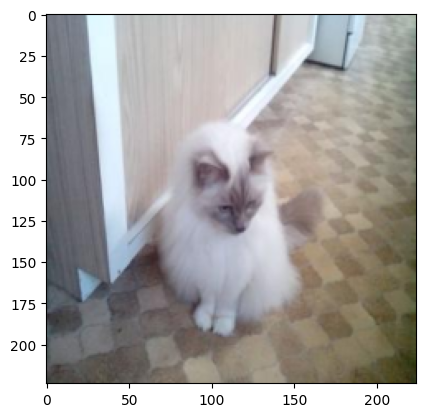

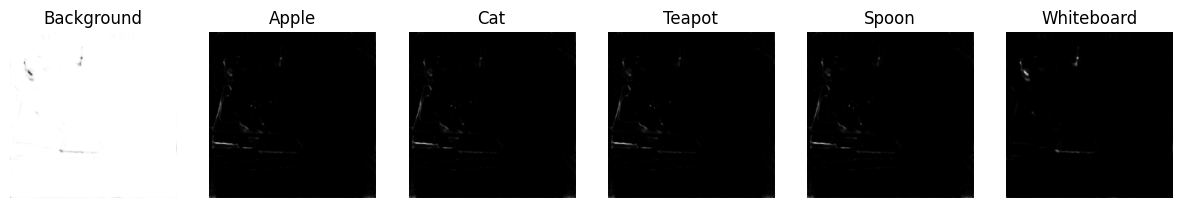

EPOCH: 72 / 92
    PRED RANGE: [0.0 1.0]
    loss: 1.1850162744522095
    PRED RANGE: [1.0630308686852553e-25 1.0]
    loss: 1.2599800825119019
    PRED RANGE: [6.168790589727249e-27 1.0]
    loss: 1.2622915506362915
    PRED RANGE: [5.6973978150601485e-22 1.0]
    loss: 1.2848193645477295
    PRED RANGE: [7.244572528066153e-20 1.0]
    loss: 1.2306873798370361
    PRED RANGE: [6.915020902469249e-31 1.0]
    loss: 1.2228871583938599
    PRED RANGE: [1.556878132692339e-29 1.0]
    loss: 1.2277626991271973
    PRED RANGE: [5.382127597913526e-22 1.0]
    loss: 1.165164828300476
    PRED RANGE: [1.9284804774867122e-28 1.0]
    loss: 1.2663416862487793
    PRED RANGE: [1.0581565248852859e-26 1.0]
    loss: 1.2509288787841797
    PRED RANGE: [2.1842811204751395e-27 1.0]
    loss: 1.278638243675232
    PRED RANGE: [6.1235371600496016e-34 1.0]
    loss: 1.2316617965698242
    PRED RANGE: [2.2507409569216586e-25 1.0]
    loss: 1.2117738723754883
    PRED RANGE: [6.07891529701687e-26 1.0]
    lo

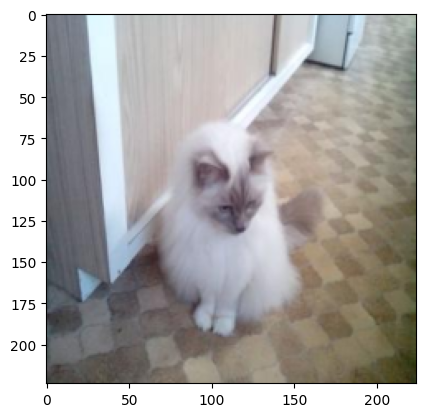

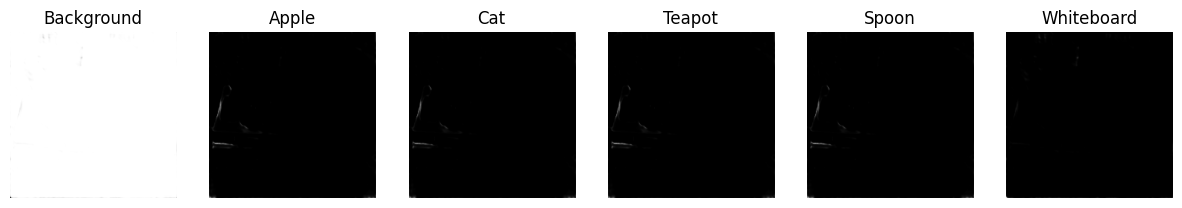

EPOCH: 73 / 92
    PRED RANGE: [0.0 1.0]
    loss: 1.2255676984786987
    PRED RANGE: [7.463692647318663e-33 1.0]
    loss: 1.2725372314453125
    PRED RANGE: [0.0 1.0]
    loss: 1.2722665071487427
    PRED RANGE: [3.7636474866109056e-33 1.0]
    loss: 1.308262586593628
    PRED RANGE: [1.2746370330350416e-22 1.0]
    loss: 1.2006744146347046
    PRED RANGE: [2.1627754395928407e-35 1.0]
    loss: 1.2573184967041016
    PRED RANGE: [9.041426293381679e-36 1.0]
    loss: 1.1914101839065552
    PRED RANGE: [2.6214789419495785e-29 1.0]
    loss: 1.2384496927261353
    PRED RANGE: [4.0477762996165576e-32 1.0]
    loss: 1.2513233423233032
    PRED RANGE: [7.840821953983609e-26 1.0]
    loss: 1.2831376791000366
    PRED RANGE: [0.0 1.0]
    loss: 1.2372926473617554
    PRED RANGE: [7.607020415227092e-36 1.0]
    loss: 1.2923275232315063
    PRED RANGE: [0.0 1.0]
    loss: 1.2247869968414307
    PRED RANGE: [5.387851344443718e-38 1.0]
    loss: 1.1999273300170898
    PRED RANGE: [6.261975048672

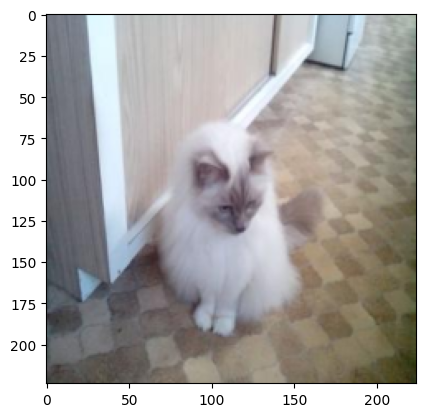

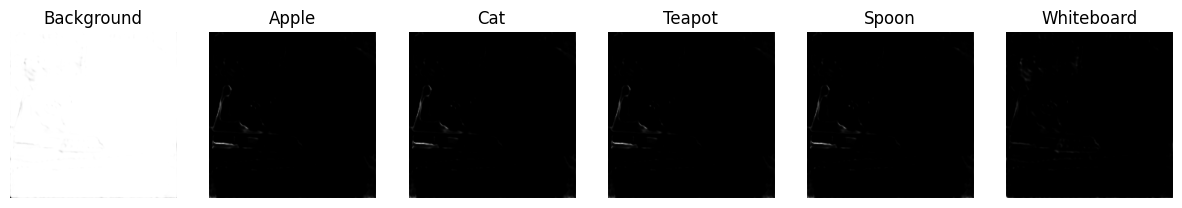

EPOCH: 74 / 92
    PRED RANGE: [1.4191920367793507e-35 1.0]
    loss: 1.2492338418960571
    PRED RANGE: [0.0 1.0]
    loss: 1.222908616065979
    PRED RANGE: [2.1397818402563582e-35 1.0]
    loss: 1.177632451057434
    PRED RANGE: [3.582734816200868e-38 1.0]
    loss: 1.2593295574188232
    PRED RANGE: [6.861906028596871e-34 1.0]
    loss: 1.2401846647262573
    PRED RANGE: [0.0 1.0]
    loss: 1.226760983467102
    PRED RANGE: [0.0 1.0]
    loss: 1.2637470960617065
    PRED RANGE: [9.733372269755214e-23 1.0]
    loss: 1.221086025238037
    PRED RANGE: [2.4359299349144305e-35 1.0]
    loss: 1.2826414108276367
    PRED RANGE: [0.0 1.0]
    loss: 1.2269105911254883
    PRED RANGE: [6.794082869821905e-32 1.0]
    loss: 1.2594456672668457
    PRED RANGE: [9.005853670451918e-36 1.0]
    loss: 1.2095232009887695
    PRED RANGE: [2.322301252899198e-28 1.0]
    loss: 1.1827338933944702
    PRED RANGE: [2.8577940753925154e-25 1.0]
    loss: 1.1925746202468872
    PRED RANGE: [1.637468038799262e

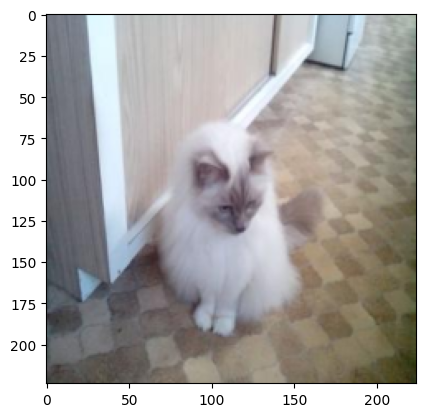

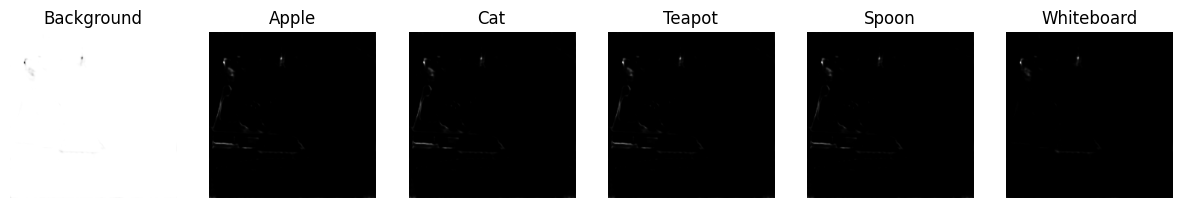

EPOCH: 75 / 92
    PRED RANGE: [2.145151616609035e-27 1.0]
    loss: 1.2386044263839722
    PRED RANGE: [0.0 1.0]
    loss: 1.229670763015747
    PRED RANGE: [6.998777996453851e-35 1.0]
    loss: 1.1961370706558228
    PRED RANGE: [1.084685277763445e-37 1.0]
    loss: 1.2345613241195679
    PRED RANGE: [2.8911675114896257e-37 1.0]
    loss: 1.1878739595413208
    PRED RANGE: [0.0 1.0]
    loss: 1.2806135416030884
    PRED RANGE: [6.665784371151407e-29 1.0]
    loss: 1.2327549457550049
    PRED RANGE: [8.203656937206487e-32 1.0]
    loss: 1.1910003423690796
    PRED RANGE: [0.0 1.0]
    loss: 1.2598419189453125
    PRED RANGE: [2.5287076517835657e-33 1.0]
    loss: 1.1418684720993042
    PRED RANGE: [0.0 1.0]
    loss: 1.229034662246704
    PRED RANGE: [0.0 1.0]
    loss: 1.2428160905838013
    PRED RANGE: [4.257353247830286e-37 1.0]
    loss: 1.2682169675827026
    PRED RANGE: [7.734284041263544e-31 1.0]
    loss: 1.2420110702514648
    PRED RANGE: [1.005454038350135e-31 1.0]
    loss:

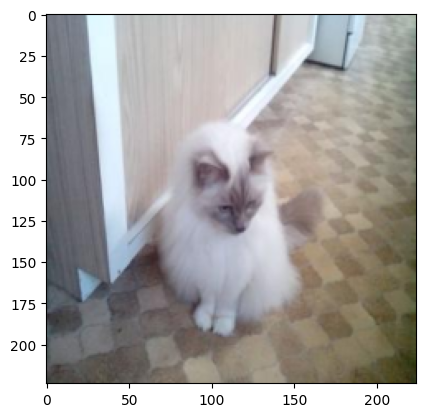

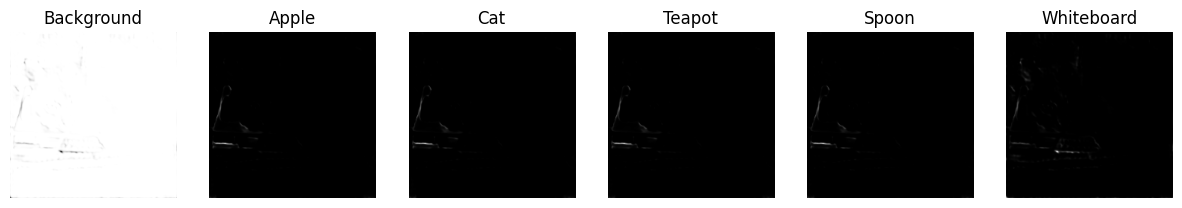

EPOCH: 76 / 92
    PRED RANGE: [0.0 1.0]
    loss: 1.1980164051055908
    PRED RANGE: [4.0943798898745405e-31 1.0]
    loss: 1.171737790107727
    PRED RANGE: [2.551786411553168e-31 1.0]
    loss: 1.1980066299438477
    PRED RANGE: [1.4102957421383504e-36 1.0]
    loss: 1.2213624715805054
    PRED RANGE: [0.0 1.0]
    loss: 1.242275357246399
    PRED RANGE: [0.0 1.0]
    loss: 1.1711317300796509
    PRED RANGE: [0.0 1.0]
    loss: 1.1854238510131836
    PRED RANGE: [2.3136263010798217e-38 1.0]
    loss: 1.1993778944015503
    PRED RANGE: [0.0 1.0]
    loss: 1.182433009147644
    PRED RANGE: [0.0 1.0]
    loss: 1.2683703899383545
    PRED RANGE: [2.2365250827262175e-36 1.0]
    loss: 1.2223063707351685
    PRED RANGE: [2.639250853548968e-35 1.0]
    loss: 1.2029989957809448
    PRED RANGE: [2.0051318874202165e-26 1.0]
    loss: 1.2054520845413208
    PRED RANGE: [6.665755051530498e-34 1.0]
    loss: 1.2507283687591553
    PRED RANGE: [1.581515401661279e-36 1.0]
    loss: 1.2462875843048

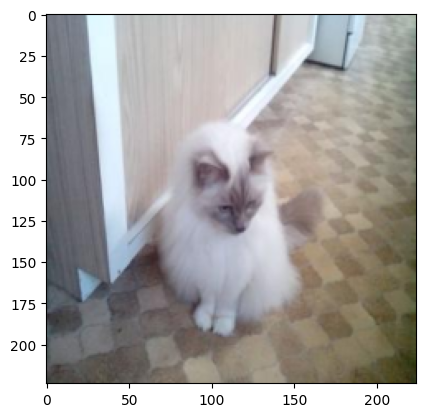

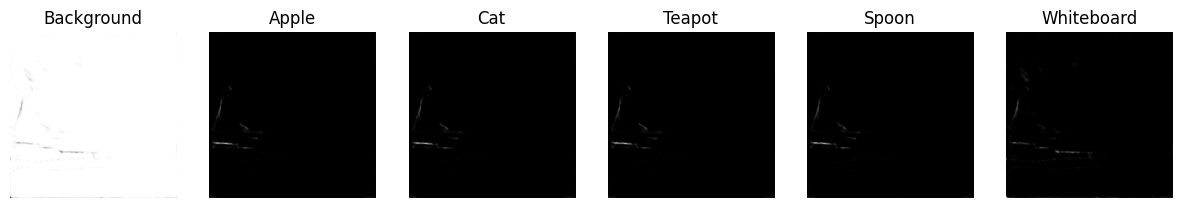

EPOCH: 77 / 92
    PRED RANGE: [0.0 1.0]
    loss: 1.2284784317016602
    PRED RANGE: [7.641049565768752e-30 1.0]
    loss: 1.2256609201431274
    PRED RANGE: [0.0 1.0]
    loss: 1.2547703981399536
    PRED RANGE: [8.260373716787617e-29 1.0]
    loss: 1.3133093118667603
    PRED RANGE: [3.811642805801877e-38 1.0]
    loss: 1.2504233121871948
    PRED RANGE: [0.0 1.0]
    loss: 1.1862961053848267
    PRED RANGE: [3.933152910244571e-28 1.0]
    loss: 1.212579607963562
    PRED RANGE: [6.932487484866041e-33 1.0]
    loss: 1.2460259199142456
    PRED RANGE: [4.883129233151149e-35 1.0]
    loss: 1.213363766670227
    PRED RANGE: [0.0 1.0]
    loss: 1.3012290000915527
    PRED RANGE: [1.6081352475325783e-35 1.0]
    loss: 1.2611926794052124
    PRED RANGE: [1.592251163980817e-37 1.0]
    loss: 1.2043955326080322
    PRED RANGE: [6.567279674880183e-29 1.0]
    loss: 1.232835054397583
    PRED RANGE: [4.546156670761098e-28 1.0]
    loss: 1.2148385047912598
    PRED RANGE: [3.1607184142278926e-

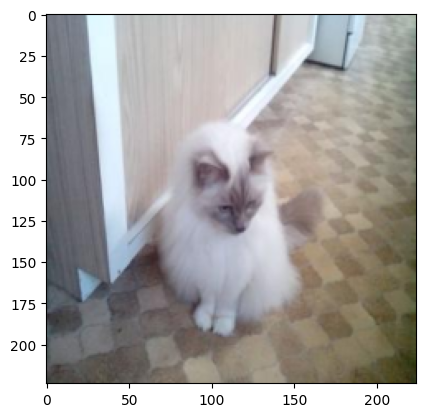

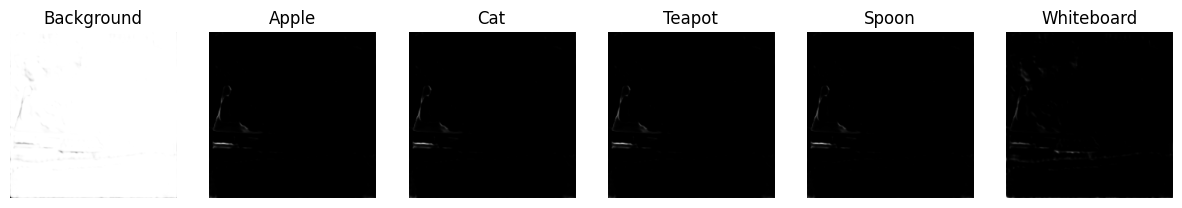

EPOCH: 78 / 92
    PRED RANGE: [5.529489315081583e-28 1.0]
    loss: 1.1964976787567139
    PRED RANGE: [0.0 1.0]
    loss: 1.2102044820785522
    PRED RANGE: [1.9363519875042216e-33 1.0]
    loss: 1.1951919794082642
    PRED RANGE: [0.0 1.0]
    loss: 1.2622082233428955
    PRED RANGE: [0.0 1.0]
    loss: 1.2186630964279175
    PRED RANGE: [1.6935404664500112e-29 1.0]
    loss: 1.205685019493103
    PRED RANGE: [0.0 1.0]
    loss: 1.202322244644165
    PRED RANGE: [0.0 1.0]
    loss: 1.1810628175735474
    PRED RANGE: [0.0 1.0]
    loss: 1.2265623807907104
    PRED RANGE: [0.0 1.0]
    loss: 1.2000259160995483
    PRED RANGE: [0.0 1.0]
    loss: 1.184273362159729
    PRED RANGE: [0.0 1.0]
    loss: 1.2181823253631592
    PRED RANGE: [0.0 1.0]
    loss: 1.2377516031265259
    PRED RANGE: [5.46474948092756e-30 1.0]
    loss: 1.210298776626587
    PRED RANGE: [0.0 1.0]
    loss: 1.2685718536376953
    PRED RANGE: [0.0 1.0]
    loss: 1.2731382846832275
    PRED RANGE: [0.0 1.0]
    loss: 

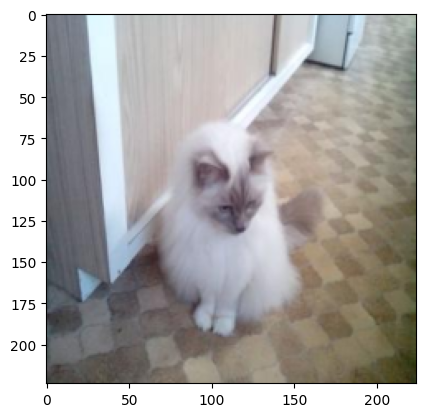

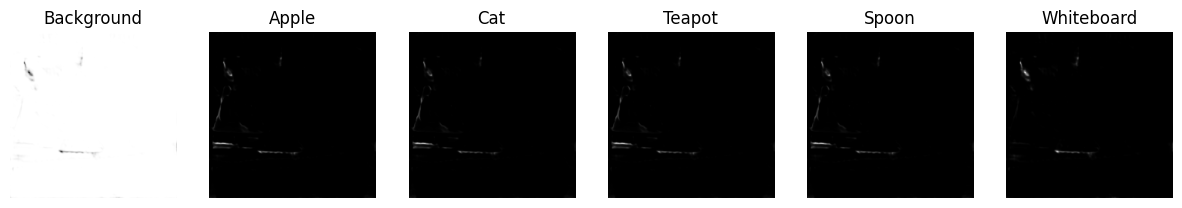

EPOCH: 79 / 92
    PRED RANGE: [0.0 1.0]
    loss: 1.2977696657180786
    PRED RANGE: [0.0 1.0]
    loss: 1.18812096118927
    PRED RANGE: [0.0 1.0]
    loss: 1.221440076828003
    PRED RANGE: [7.81034133386163e-36 1.0]
    loss: 1.2477344274520874
    PRED RANGE: [0.0 1.0]
    loss: 1.1721585988998413
    PRED RANGE: [0.0 1.0]
    loss: 1.2181605100631714
    PRED RANGE: [6.951624227853823e-25 1.0]
    loss: 1.3158758878707886
    PRED RANGE: [7.251717260369627e-29 1.0]
    loss: 1.2109971046447754
    PRED RANGE: [0.0 1.0]
    loss: 1.1824541091918945
    PRED RANGE: [0.0 1.0]
    loss: 1.236243724822998
    PRED RANGE: [0.0 1.0]
    loss: 1.2366870641708374
    PRED RANGE: [1.0113476064775307e-27 1.0]
    loss: 1.3369426727294922
    PRED RANGE: [0.0 1.0]
    loss: 1.170591115951538
    PRED RANGE: [1.133672180226811e-29 1.0]
    loss: 1.2524969577789307
    PRED RANGE: [0.0 1.0]
    loss: 1.2792969942092896
    PRED RANGE: [0.0 1.0]
    loss: 1.2502193450927734
    PRED RANGE: [6.9

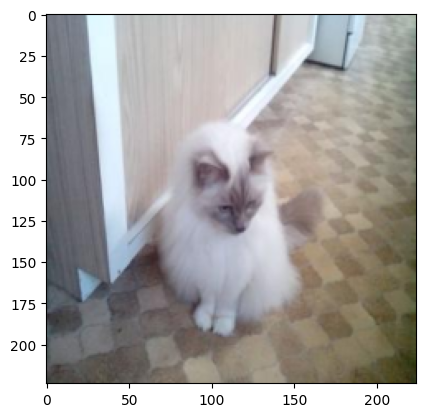

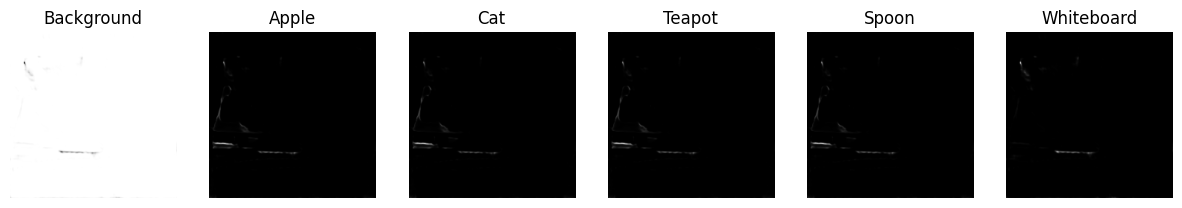

EPOCH: 80 / 92
    PRED RANGE: [1.478143164568866e-34 1.0]
    loss: 1.210525393486023
    PRED RANGE: [0.0 1.0]
    loss: 1.1916533708572388
    PRED RANGE: [2.4362013215707114e-30 1.0]
    loss: 1.207166075706482
    PRED RANGE: [0.0 1.0]
    loss: 1.2398197650909424
    PRED RANGE: [1.0875589098214545e-31 1.0]
    loss: 1.2393465042114258
    PRED RANGE: [0.0 1.0]
    loss: 1.2129474878311157
    PRED RANGE: [0.0 1.0]
    loss: 1.2316770553588867
    PRED RANGE: [8.267330380517859e-33 1.0]
    loss: 1.227809190750122
    PRED RANGE: [0.0 1.0]
    loss: 1.223824381828308
    PRED RANGE: [0.0 1.0]
    loss: 1.1977128982543945
    PRED RANGE: [0.0 1.0]
    loss: 1.2117432355880737
    PRED RANGE: [1.433870764197911e-34 1.0]
    loss: 1.1891567707061768
    PRED RANGE: [1.023673330922061e-30 1.0]
    loss: 1.2257905006408691
    PRED RANGE: [0.0 1.0]
    loss: 1.2300053834915161
    PRED RANGE: [0.0 1.0]
    loss: 1.193833589553833
    PRED RANGE: [0.0 1.0]
    loss: 1.2849904298782349


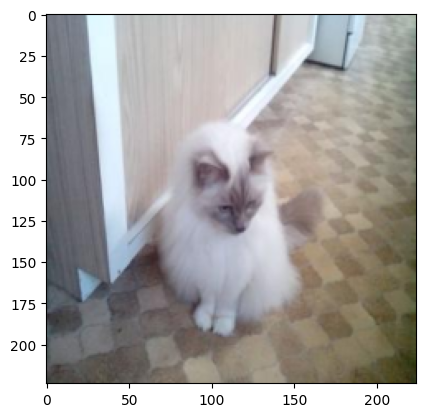

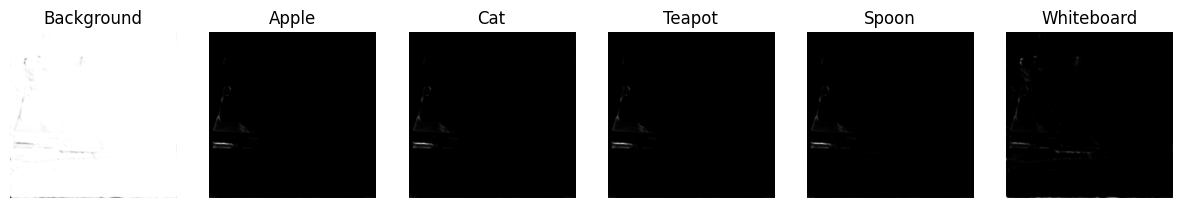

EPOCH: 81 / 92
    PRED RANGE: [0.0 1.0]
    loss: 1.2169315814971924
    PRED RANGE: [0.0 1.0]
    loss: 1.2519680261611938
    PRED RANGE: [3.089297661879897e-36 1.0]
    loss: 1.276477575302124
    PRED RANGE: [2.6024302992271286e-37 1.0]
    loss: 1.1957746744155884
    PRED RANGE: [0.0 1.0]
    loss: 1.2200278043746948
    PRED RANGE: [0.0 1.0]
    loss: 1.192954659461975
    PRED RANGE: [1.7559924411216633e-36 1.0]
    loss: 1.290454387664795
    PRED RANGE: [0.0 1.0]
    loss: 1.263736605644226
    PRED RANGE: [0.0 1.0]
    loss: 1.2612476348876953
    PRED RANGE: [0.0 1.0]
    loss: 1.2416284084320068
    PRED RANGE: [0.0 1.0]
    loss: 1.239837408065796
    PRED RANGE: [0.0 1.0]
    loss: 1.2167847156524658
    PRED RANGE: [2.4793633355195287e-38 1.0]
    loss: 1.2450039386749268
    PRED RANGE: [4.007497912217235e-33 1.0]
    loss: 1.1918532848358154
    PRED RANGE: [0.0 1.0]
    loss: 1.2495505809783936
    PRED RANGE: [0.0 1.0]
    loss: 1.1895685195922852
    PRED RANGE: [

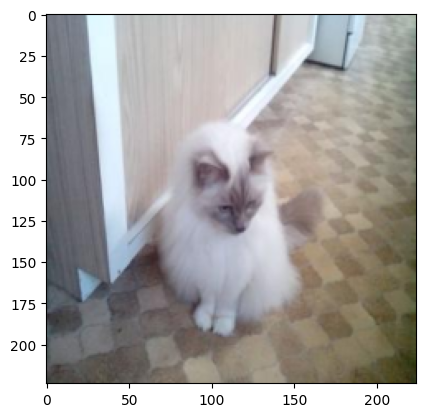

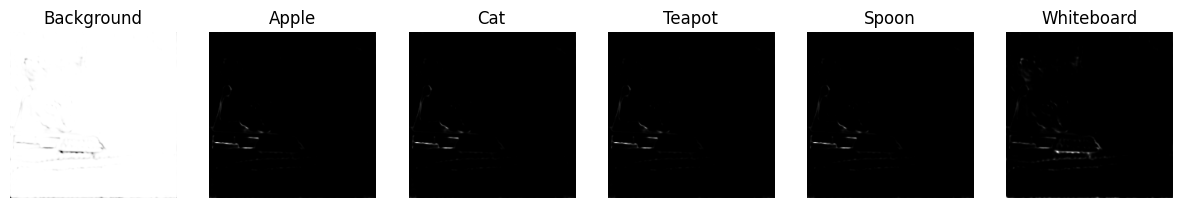

EPOCH: 82 / 92
    PRED RANGE: [0.0 1.0]
    loss: 1.2451002597808838
    PRED RANGE: [0.0 1.0]
    loss: 1.2363874912261963
    PRED RANGE: [0.0 1.0]
    loss: 1.2072725296020508
    PRED RANGE: [0.0 1.0]
    loss: 1.1994240283966064
    PRED RANGE: [0.0 1.0]
    loss: 1.2414690256118774
    PRED RANGE: [1.7745801978046692e-32 1.0]
    loss: 1.228555679321289
    PRED RANGE: [0.0 1.0]
    loss: 1.2353708744049072
    PRED RANGE: [0.0 1.0]
    loss: 1.256063461303711
    PRED RANGE: [4.1286350295265703e-32 1.0]
    loss: 1.1820100545883179
    PRED RANGE: [0.0 1.0]
    loss: 1.2894527912139893
    PRED RANGE: [1.204509058368591e-35 1.0]
    loss: 1.146222472190857
    PRED RANGE: [0.0 1.0]
    loss: 1.2121812105178833
    PRED RANGE: [0.0 1.0]
    loss: 1.2875386476516724
    PRED RANGE: [0.0 1.0]
    loss: 1.2026751041412354
    PRED RANGE: [0.0 1.0]
    loss: 1.2773274183273315
    PRED RANGE: [0.0 1.0]
    loss: 1.1999820470809937
    PRED RANGE: [0.0 1.0]
    loss: 1.22925066947937

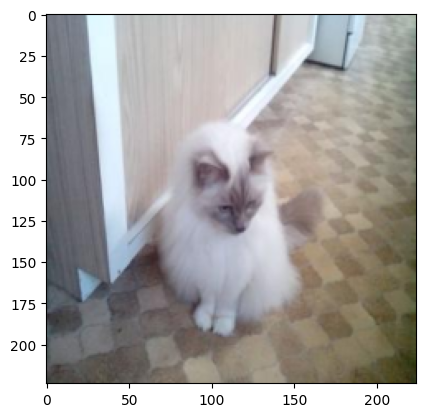

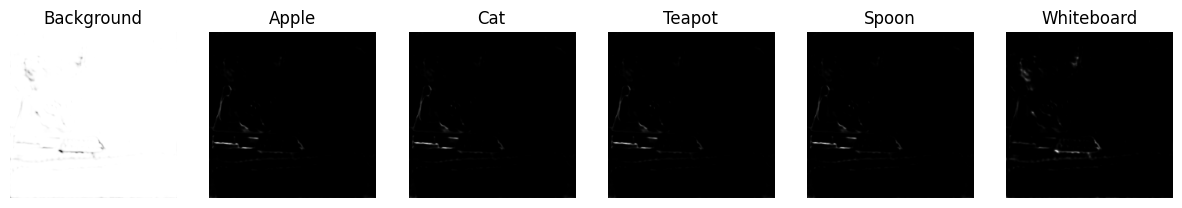

EPOCH: 83 / 92
    PRED RANGE: [1.2640975130220059e-33 1.0]
    loss: 1.2109864950180054
    PRED RANGE: [1.4130321708745534e-35 1.0]
    loss: 1.2045038938522339
    PRED RANGE: [8.162562747544144e-36 1.0]
    loss: 1.2044739723205566
    PRED RANGE: [0.0 1.0]
    loss: 1.2967544794082642
    PRED RANGE: [1.0198610798664504e-34 1.0]
    loss: 1.1846530437469482
    PRED RANGE: [0.0 1.0]
    loss: 1.2532628774642944
    PRED RANGE: [0.0 1.0]
    loss: 1.2073920965194702
    PRED RANGE: [0.0 1.0]
    loss: 1.2609705924987793
    PRED RANGE: [3.623019538612888e-30 1.0]
    loss: 1.2632681131362915
    PRED RANGE: [0.0 1.0]
    loss: 1.2086929082870483
    PRED RANGE: [0.0 1.0]
    loss: 1.208134412765503
    PRED RANGE: [0.0 1.0]
    loss: 1.243873119354248
    PRED RANGE: [2.0999967805150156e-34 1.0]
    loss: 1.226401448249817
    PRED RANGE: [0.0 1.0]
    loss: 1.2546672821044922
    PRED RANGE: [0.0 1.0]
    loss: 1.1960259675979614
    PRED RANGE: [0.0 1.0]
    loss: 1.3282994031906

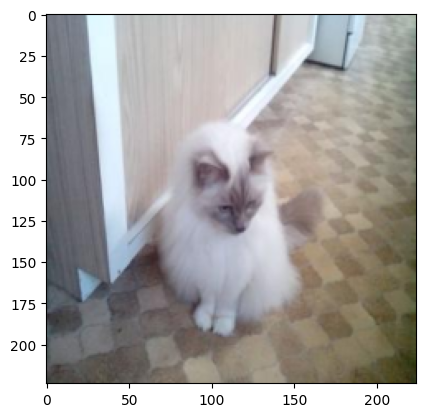

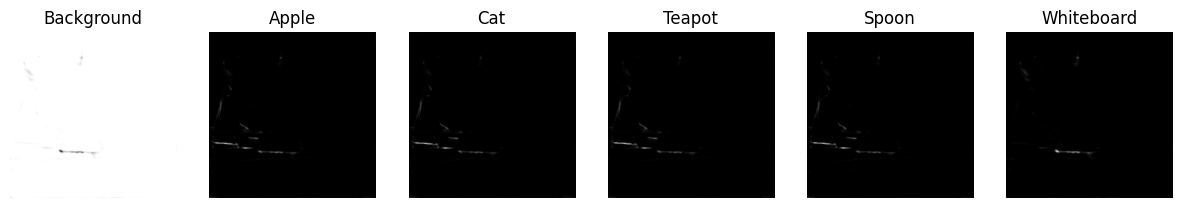

EPOCH: 84 / 92
    PRED RANGE: [0.0 1.0]
    loss: 1.2524296045303345
    PRED RANGE: [0.0 1.0]
    loss: 1.3019123077392578
    PRED RANGE: [0.0 1.0]
    loss: 1.2418681383132935
    PRED RANGE: [6.076652384196062e-34 1.0]
    loss: 1.2376759052276611
    PRED RANGE: [2.123179777246177e-30 1.0]
    loss: 1.2570232152938843
    PRED RANGE: [0.0 1.0]
    loss: 1.2447341680526733
    PRED RANGE: [0.0 1.0]
    loss: 1.1579468250274658
    PRED RANGE: [0.0 1.0]
    loss: 1.1799105405807495
    PRED RANGE: [0.0 1.0]
    loss: 1.2697906494140625
    PRED RANGE: [7.664699563997634e-36 1.0]
    loss: 1.1493504047393799
    PRED RANGE: [0.0 1.0]
    loss: 1.209532618522644
    PRED RANGE: [0.0 1.0]
    loss: 1.2424854040145874
    PRED RANGE: [0.0 1.0]
    loss: 1.1760796308517456
    PRED RANGE: [0.0 1.0]
    loss: 1.2172330617904663
    PRED RANGE: [0.0 1.0]
    loss: 1.260335922241211
    PRED RANGE: [0.0 1.0]
    loss: 1.2202844619750977
    PRED RANGE: [0.0 1.0]
    loss: 1.234342098236084

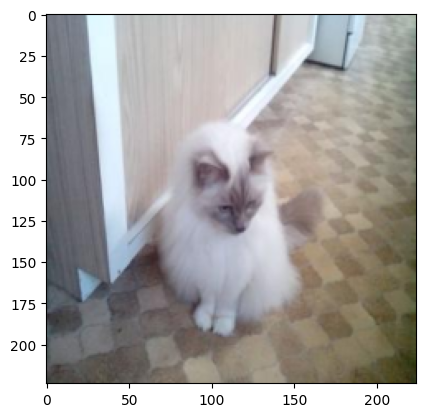

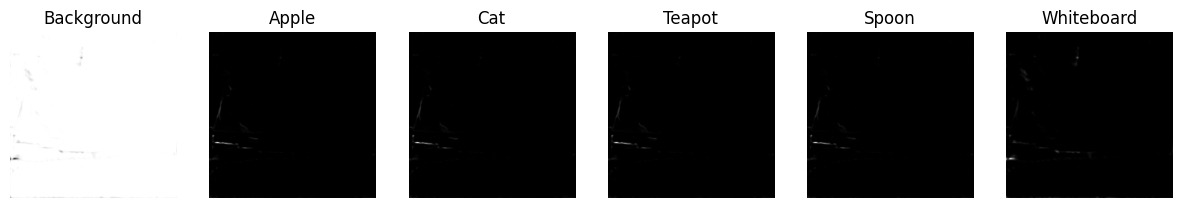

EPOCH: 85 / 92
    PRED RANGE: [0.0 1.0]
    loss: 1.1760225296020508
    PRED RANGE: [0.0 1.0]
    loss: 1.2803874015808105
    PRED RANGE: [0.0 1.0]
    loss: 1.2187789678573608
    PRED RANGE: [2.3496186521360046e-38 1.0]
    loss: 1.1969267129898071
    PRED RANGE: [2.872390094274546e-32 1.0]
    loss: 1.1897276639938354
    PRED RANGE: [0.0 1.0]
    loss: 1.2385883331298828
    PRED RANGE: [0.0 1.0]
    loss: 1.1738258600234985
    PRED RANGE: [0.0 1.0]
    loss: 1.2409725189208984
    PRED RANGE: [0.0 1.0]
    loss: 1.2452608346939087
    PRED RANGE: [0.0 1.0]
    loss: 1.247809886932373
    PRED RANGE: [6.682130963489891e-38 1.0]
    loss: 1.1861737966537476
    PRED RANGE: [0.0 1.0]
    loss: 1.2566142082214355
    PRED RANGE: [4.755791748474309e-38 1.0]
    loss: 1.2115904092788696
    PRED RANGE: [0.0 1.0]
    loss: 1.277976155281067
    PRED RANGE: [0.0 1.0]
    loss: 1.2033506631851196
    PRED RANGE: [0.0 1.0]
    loss: 1.2542293071746826
    PRED RANGE: [0.0 1.0]
    loss

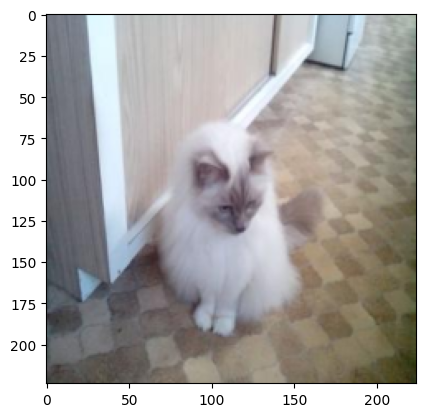

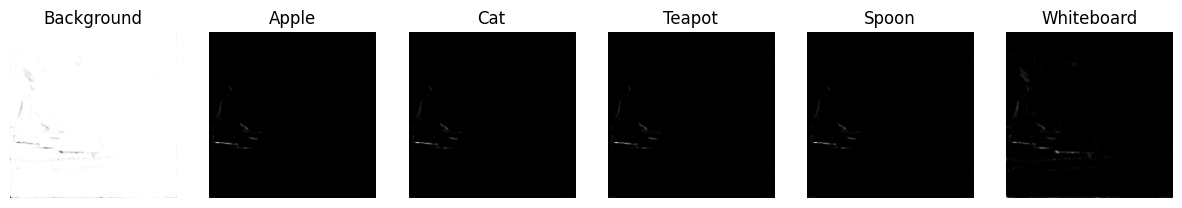

EPOCH: 86 / 92
    PRED RANGE: [0.0 1.0]
    loss: 1.2645611763000488
    PRED RANGE: [0.0 1.0]
    loss: 1.2254760265350342
    PRED RANGE: [0.0 1.0]
    loss: 1.2178096771240234
    PRED RANGE: [0.0 1.0]
    loss: 1.2392237186431885
    PRED RANGE: [0.0 1.0]
    loss: 1.31328284740448
    PRED RANGE: [0.0 1.0]
    loss: 1.2497981786727905
    PRED RANGE: [0.0 1.0]
    loss: 1.2268234491348267
    PRED RANGE: [4.227680742370782e-29 1.0]
    loss: 1.274585485458374
    PRED RANGE: [0.0 1.0]
    loss: 1.1971746683120728
    PRED RANGE: [0.0 1.0]
    loss: 1.249819040298462
    PRED RANGE: [0.0 1.0]
    loss: 1.2467892169952393
    PRED RANGE: [0.0 1.0]
    loss: 1.1911004781723022
    PRED RANGE: [0.0 1.0]
    loss: 1.229286789894104
    PRED RANGE: [0.0 1.0]
    loss: 1.2872971296310425
    PRED RANGE: [1.1525726981813435e-26 1.0]
    loss: 1.277421474456787
    PRED RANGE: [0.0 1.0]
    loss: 1.2957630157470703
    PRED RANGE: [0.0 1.0]
    loss: 1.2748295068740845
    PRED RANGE: [0.

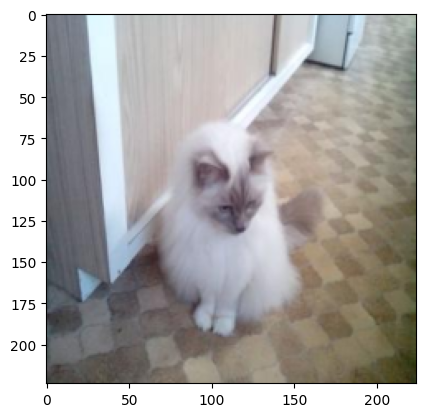

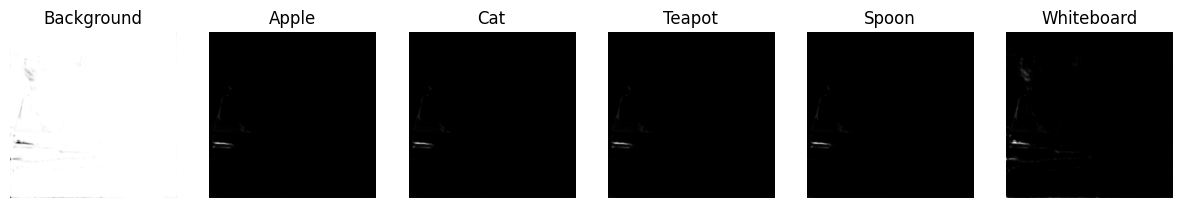

EPOCH: 87 / 92
    PRED RANGE: [0.0 1.0]
    loss: 1.2153611183166504
    PRED RANGE: [0.0 1.0]
    loss: 1.2947590351104736
    PRED RANGE: [9.910334745879345e-38 1.0]
    loss: 1.2032853364944458
    PRED RANGE: [0.0 1.0]
    loss: 1.2310234308242798
    PRED RANGE: [0.0 1.0]
    loss: 1.1809183359146118
    PRED RANGE: [1.0698474848083556e-34 1.0]
    loss: 1.2097784280776978
    PRED RANGE: [7.100125963971498e-37 1.0]
    loss: 1.2025477886199951
    PRED RANGE: [1.4064256289577126e-28 1.0]
    loss: 1.2424941062927246
    PRED RANGE: [1.9962193910422867e-37 1.0]
    loss: 1.1818619966506958
    PRED RANGE: [3.3122732824581565e-38 1.0]
    loss: 1.194077491760254
    PRED RANGE: [0.0 1.0]
    loss: 1.2885079383850098
    PRED RANGE: [0.0 1.0]
    loss: 1.2460472583770752
    PRED RANGE: [0.0 1.0]
    loss: 1.2359251976013184
    PRED RANGE: [0.0 1.0]
    loss: 1.2221390008926392
    PRED RANGE: [1.290524766943495e-35 1.0]
    loss: 1.1952368021011353
    PRED RANGE: [0.0 1.0]
    l

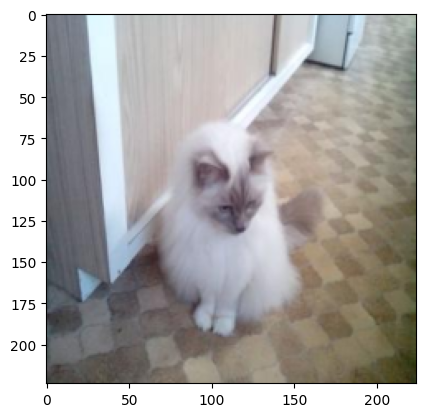

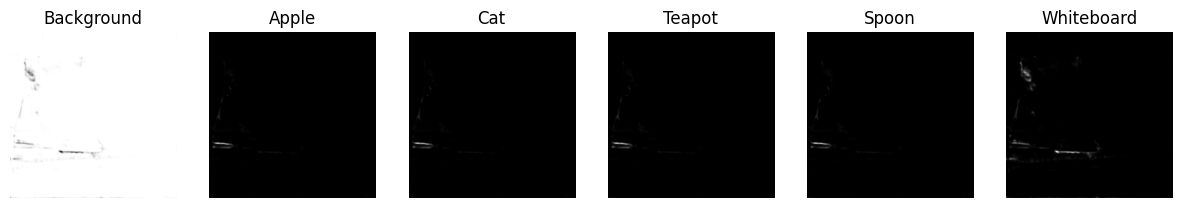

EPOCH: 88 / 92
    PRED RANGE: [0.0 1.0]
    loss: 1.1589616537094116
    PRED RANGE: [0.0 1.0]
    loss: 1.3283900022506714
    PRED RANGE: [0.0 1.0]
    loss: 1.1974513530731201
    PRED RANGE: [1.8548400868113349e-34 1.0]
    loss: 1.2275562286376953
    PRED RANGE: [0.0 1.0]
    loss: 1.2613277435302734
    PRED RANGE: [0.0 1.0]
    loss: 1.2606157064437866
    PRED RANGE: [0.0 1.0]
    loss: 1.217246174812317
    PRED RANGE: [0.0 1.0]
    loss: 1.211692214012146
    PRED RANGE: [0.0 1.0]
    loss: 1.2155194282531738
    PRED RANGE: [0.0 1.0]
    loss: 1.2416921854019165
    PRED RANGE: [0.0 1.0]
    loss: 1.2079265117645264
    PRED RANGE: [0.0 1.0]
    loss: 1.2616735696792603
    PRED RANGE: [0.0 1.0]
    loss: 1.2776918411254883
    PRED RANGE: [0.0 1.0]
    loss: 1.266903281211853
    PRED RANGE: [0.0 1.0]
    loss: 1.2401635646820068
    PRED RANGE: [0.0 1.0]
    loss: 1.196135401725769
    PRED RANGE: [0.0 1.0]
    loss: 1.184638500213623
    PRED RANGE: [3.216144723483309e-

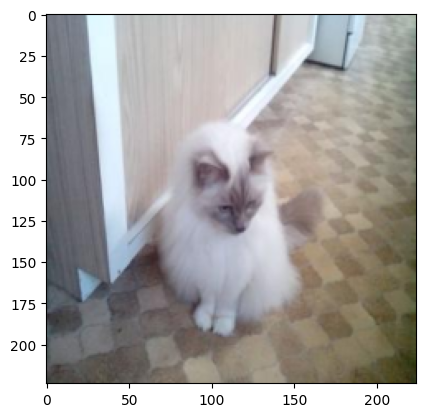

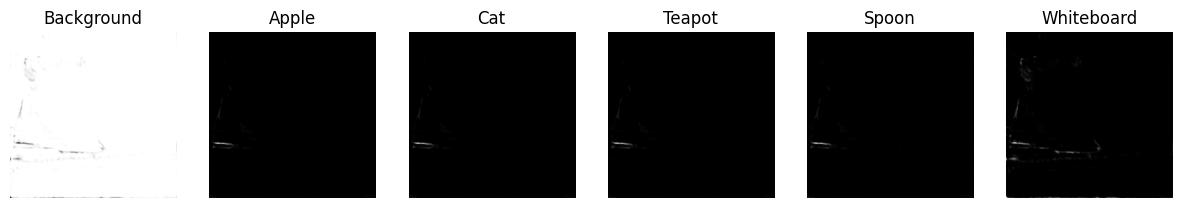

EPOCH: 89 / 92
    PRED RANGE: [0.0 1.0]
    loss: 1.3137603998184204
    PRED RANGE: [0.0 1.0]
    loss: 1.2041029930114746
    PRED RANGE: [0.0 1.0]
    loss: 1.1987545490264893
    PRED RANGE: [0.0 1.0]
    loss: 1.180920958518982
    PRED RANGE: [0.0 1.0]
    loss: 1.2339444160461426
    PRED RANGE: [2.0830209747009146e-36 1.0]
    loss: 1.2243154048919678
    PRED RANGE: [0.0 1.0]
    loss: 1.230156421661377
    PRED RANGE: [0.0 1.0]
    loss: 1.224279522895813
    PRED RANGE: [0.0 1.0]
    loss: 1.2486658096313477
    PRED RANGE: [0.0 1.0]
    loss: 1.1735574007034302
    PRED RANGE: [0.0 1.0]
    loss: 1.249673843383789
    PRED RANGE: [0.0 1.0]
    loss: 1.2122563123703003
    PRED RANGE: [1.3900441318903773e-37 1.0]
    loss: 1.2475981712341309
    PRED RANGE: [0.0 1.0]
    loss: 1.28377366065979
    PRED RANGE: [0.0 1.0]
    loss: 1.1868637800216675
    PRED RANGE: [1.1534899919709818e-34 1.0]
    loss: 1.2365275621414185
    PRED RANGE: [1.2687993067543027e-33 1.0]
    loss:

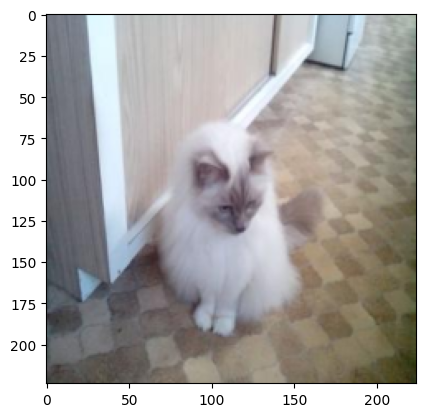

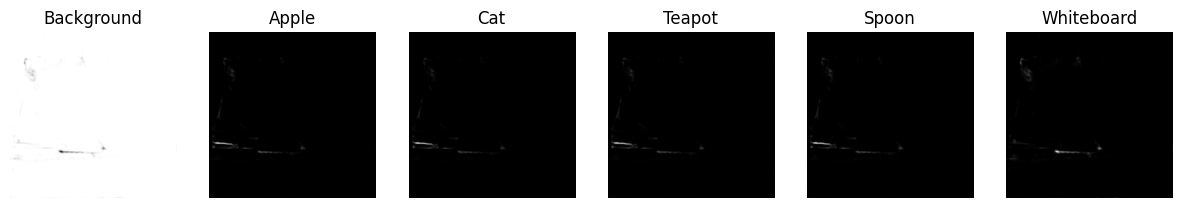

EPOCH: 90 / 92
    PRED RANGE: [6.286670741587482e-32 1.0]
    loss: 1.2181260585784912
    PRED RANGE: [0.0 1.0]
    loss: 1.2129337787628174
    PRED RANGE: [0.0 1.0]
    loss: 1.1892344951629639
    PRED RANGE: [0.0 1.0]
    loss: 1.2284542322158813
    PRED RANGE: [0.0 1.0]
    loss: 1.2463655471801758
    PRED RANGE: [1.0818224973894417e-31 1.0]
    loss: 1.2164825201034546
    PRED RANGE: [0.0 1.0]
    loss: 1.1850866079330444
    PRED RANGE: [7.357311466514162e-31 1.0]
    loss: 1.2671566009521484
    PRED RANGE: [0.0 1.0]
    loss: 1.2418076992034912
    PRED RANGE: [0.0 1.0]
    loss: 1.2753162384033203
    PRED RANGE: [3.0060561446537235e-32 1.0]
    loss: 1.2413440942764282
    PRED RANGE: [0.0 1.0]
    loss: 1.2457890510559082
    PRED RANGE: [0.0 1.0]
    loss: 1.2495156526565552
    PRED RANGE: [9.844965181453486e-37 1.0]
    loss: 1.203272819519043
    PRED RANGE: [0.0 1.0]
    loss: 1.175808310508728
    PRED RANGE: [4.99000589484033e-38 1.0]
    loss: 1.166944265365600

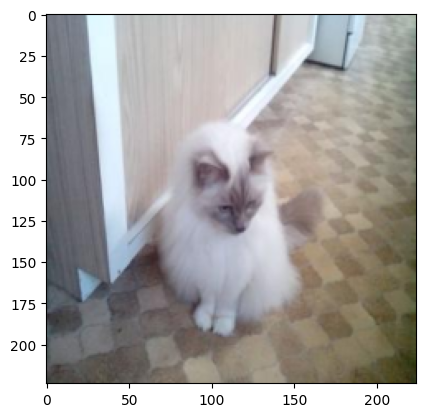

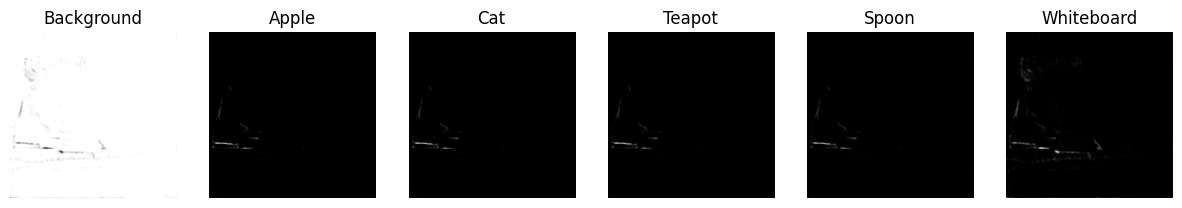

EPOCH: 91 / 92
    PRED RANGE: [7.002775853888942e-36 1.0]
    loss: 1.2322429418563843
    PRED RANGE: [0.0 1.0]
    loss: 1.218070149421692
    PRED RANGE: [0.0 1.0]
    loss: 1.2337288856506348
    PRED RANGE: [1.0039330883649196e-35 1.0]
    loss: 1.200528621673584
    PRED RANGE: [0.0 1.0]
    loss: 1.2522090673446655
    PRED RANGE: [0.0 1.0]
    loss: 1.204033613204956
    PRED RANGE: [4.845061867055421e-31 1.0]
    loss: 1.2487674951553345
    PRED RANGE: [0.0 1.0]
    loss: 1.1914803981781006
    PRED RANGE: [0.0 1.0]
    loss: 1.226889967918396
    PRED RANGE: [0.0 1.0]
    loss: 1.229140043258667
    PRED RANGE: [0.0 1.0]
    loss: 1.1751594543457031
    PRED RANGE: [0.0 1.0]
    loss: 1.212644338607788
    PRED RANGE: [6.242392294997049e-38 1.0]
    loss: 1.19728684425354
    PRED RANGE: [0.0 1.0]
    loss: 1.236433982849121
    PRED RANGE: [0.0 1.0]
    loss: 1.2647162675857544
    PRED RANGE: [0.0 1.0]
    loss: 1.239666223526001
    PRED RANGE: [1.8536401309461038e-38 1.

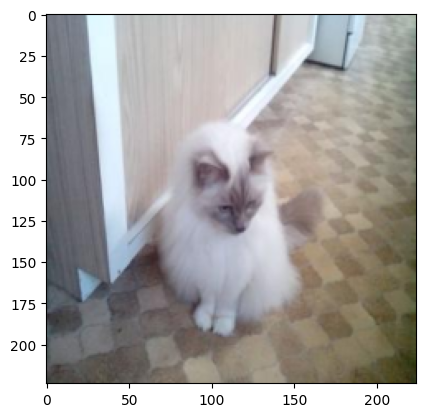

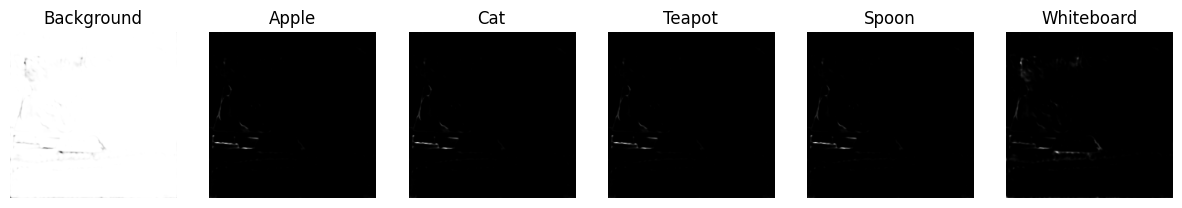

EPOCH: 92 / 92
    PRED RANGE: [0.0 1.0]
    loss: 1.2520509958267212
    PRED RANGE: [0.0 1.0]
    loss: 1.220168113708496
    PRED RANGE: [0.0 1.0]
    loss: 1.2158845663070679
    PRED RANGE: [0.0 1.0]
    loss: 1.1656183004379272
    PRED RANGE: [0.0 1.0]
    loss: 1.2329370975494385
    PRED RANGE: [0.0 1.0]
    loss: 1.1891030073165894
    PRED RANGE: [0.0 1.0]
    loss: 1.1757140159606934
    PRED RANGE: [1.37098543245158e-35 1.0]
    loss: 1.2673311233520508
    PRED RANGE: [0.0 1.0]
    loss: 1.2482473850250244
    PRED RANGE: [0.0 1.0]
    loss: 1.2277313470840454
    PRED RANGE: [4.0557593756265795e-32 1.0]
    loss: 1.2022277116775513
    PRED RANGE: [0.0 1.0]
    loss: 1.2014082670211792
    PRED RANGE: [0.0 1.0]
    loss: 1.2121514081954956
    PRED RANGE: [0.0 1.0]
    loss: 1.1806437969207764
    PRED RANGE: [1.31767023314253e-38 1.0]
    loss: 1.2345404624938965
    PRED RANGE: [0.0 1.0]
    loss: 1.2327524423599243
    PRED RANGE: [0.0 1.0]
    loss: 1.196215152740478

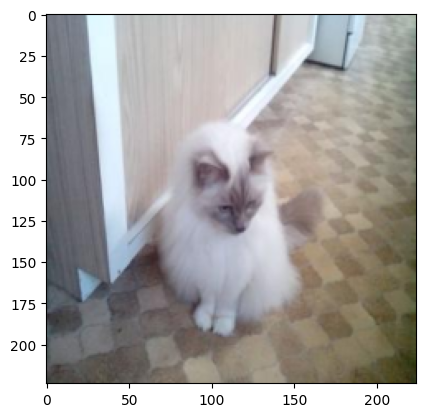

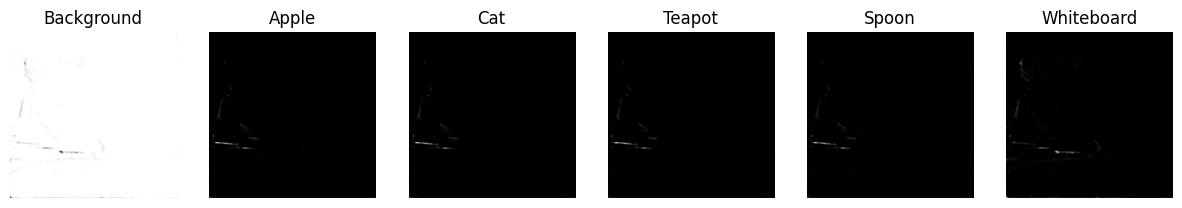

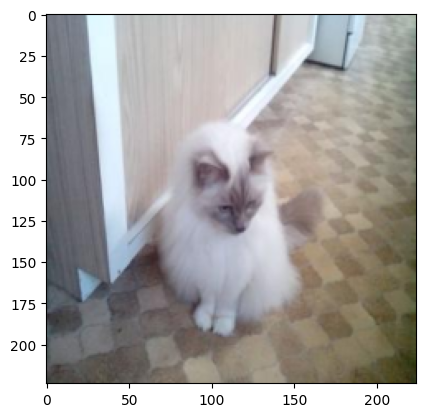

In [13]:
save = None
save = 'lab3/save/net_attempt5-61.pt' # <- actually 24th epoch
if save is None:
  model = Net(train_dataset[0][0].shape[0], num_classes = cs.num_classes).to(device)
else:
  model = torch.load(save).to(device)
print(f'Parameter count: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

EPOCHS = 30

train_iou, valid_iou, train_dice, valid_dice, train_micro, valid_micro, train_macro, valid_macro, train_loss, valid_loss =(
  train_and_eval(model, train_ld, valid_ld, offset = 62, epoch_count = EPOCHS, learning_rate = 0.2e-3))

In [14]:
iter = train_ld.__iter__()
img: torch.Tensor; mask: torch.Tensor; prediction: torch.Tensor
imgs, masks = next(iter)

# prediction = model(img.unsqueeze(0).to(device)).cpu().detach().squeeze(0) img.shape, mask.unique(), mask.max()
# for i in range(10):
#   print(masks[0].max())

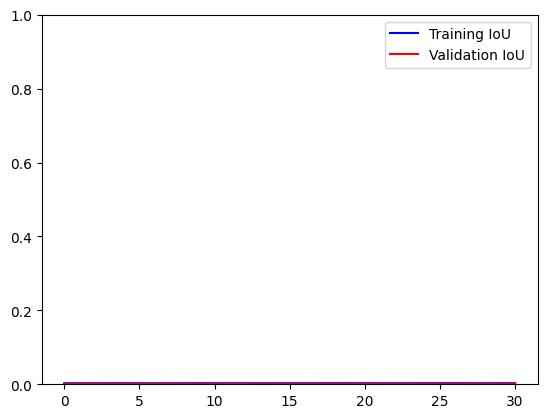

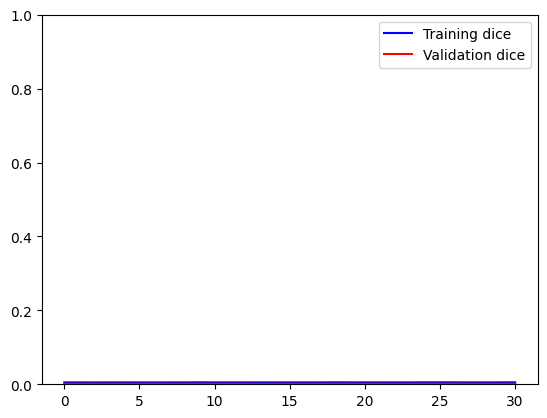

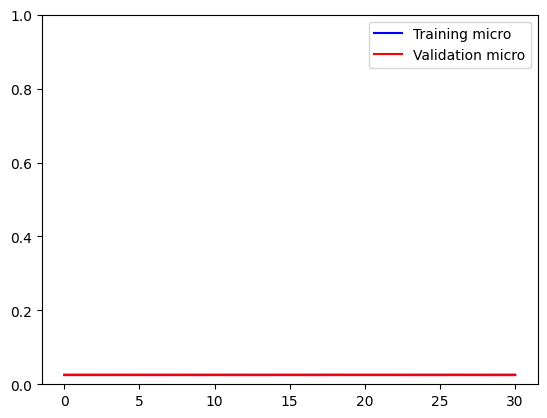

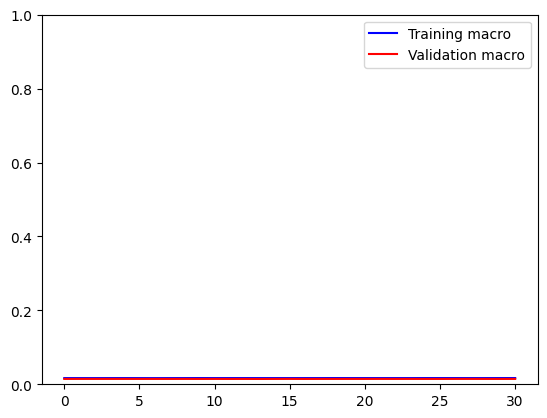

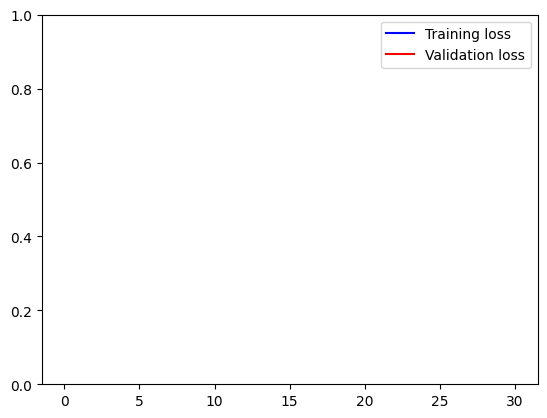

In [15]:
plot(train_iou, valid_iou)
plot(train_dice, valid_dice, label = "dice")
plot(train_micro, valid_micro, label = "micro")
plot(train_macro, valid_macro, label = "macro")
plot(train_loss, valid_loss, label = "loss")


In [16]:
model = torch.load('lab3/net_attempt4.pt').to(device)

FileNotFoundError: [Errno 2] No such file or directory: 'lab3/net_attempt4.pt'

In [ ]:
from lab3.net import DIM

img, true_mask = valid_dataset[37]
prediction = model(img.unsqueeze(0).to(device)).cpu().detach().squeeze(0)

# true_mask  = true_mask > .5
# prediction = prediction > .5

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (7, 7))
display_img_with_masks(ax1, img, true_mask)
display_img_with_masks(ax2, img, prediction)

display_masks(ax3, true_mask)
display_masks(ax4, prediction)

display_img_with_masks_nouveau(img, true_mask, cs.classes)
display_img_with_masks_nouveau(img, prediction, cs.classes)

prediction.min(), prediction.max(), 
# (
#   torch.max(true_mask),
#   torch.max(prediction),
# )
# (
#   torch.count_nonzero(true_mask),
# ),(
#   torch.count_nonzero(true_mask != .0),
#   (true_mask != .0).float()[0,0,0]
# )
# prediction.sum() / (DIM * DIM * cs.num_classes)
# prediction.type()
model